In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install torchinfo

In [4]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

In [5]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [6]:
base_dir = "/content/drive/MyDrive/Coffee Bean Dataset"

def create_dataframe(data_dir):
    file_paths = []
    labels = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # skip files, only consider folders
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            file_paths.append(image_path)
            labels.append(class_name)

    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    df = df.sample(frac=1).reset_index(drop=True)  # shuffle
    return df

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

# Print few rows to confirm
print("Train:", train_df.head())
print("Test:", test_df.head())

Train:                                            file_path   label
0  /content/drive/MyDrive/Coffee Bean Dataset/tra...   Green
1  /content/drive/MyDrive/Coffee Bean Dataset/tra...   Green
2  /content/drive/MyDrive/Coffee Bean Dataset/tra...  Medium
3  /content/drive/MyDrive/Coffee Bean Dataset/tra...    Dark
4  /content/drive/MyDrive/Coffee Bean Dataset/tra...  Medium
Test:                                            file_path   label
0  /content/drive/MyDrive/Coffee Bean Dataset/tes...  Medium
1  /content/drive/MyDrive/Coffee Bean Dataset/tes...   Light
2  /content/drive/MyDrive/Coffee Bean Dataset/tes...  Medium
3  /content/drive/MyDrive/Coffee Bean Dataset/tes...   Light
4  /content/drive/MyDrive/Coffee Bean Dataset/tes...    Dark


In [7]:
# Define transformations
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Map class names to integer labels
label_to_idx = {label: idx for idx, label in enumerate(sorted(train_df['label'].unique()))}

class CoffeeBeanDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['file_path']
        label_name = self.dataframe.iloc[idx]['label']
        label = label_to_idx[label_name]

        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
train_dataset = CoffeeBeanDataset(train_df, transform=train_transforms)
test_dataset = CoffeeBeanDataset(test_df, transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Class Distribution:
Green: 300 images
Medium: 300 images
Dark: 300 images
Light: 300 images


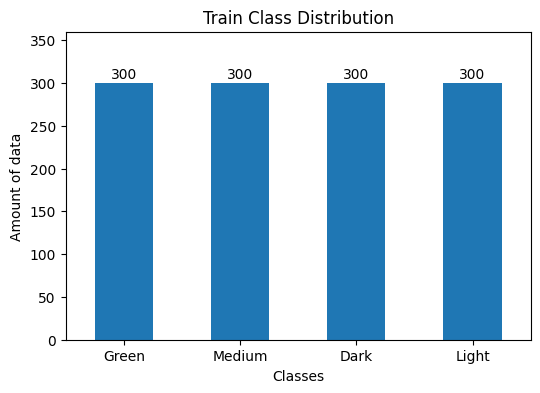


Test Class Distribution:
Medium: 100 images
Light: 100 images
Dark: 100 images
Green: 100 images


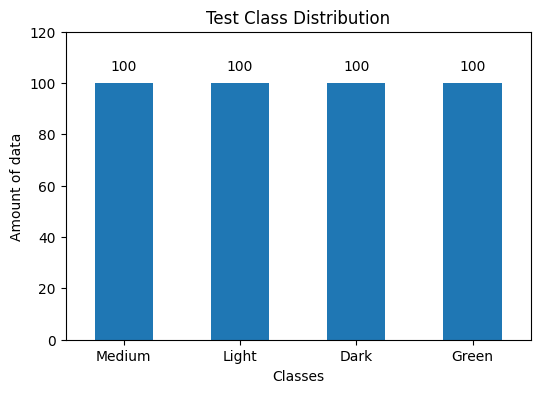

In [9]:
from collections import Counter
import matplotlib.pyplot as plt

# Label distribution for train data
train_label_counts = Counter(train_df["label"])

print("Train Class Distribution:")
for k, v in train_label_counts.items():
    print(f"{k}: {v} images")

plt.figure(figsize=(6, 4))
ax = train_df['label'].value_counts().plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(train_df['label'].value_counts()):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(train_df['label'].value_counts()) * 1.2)
plt.title('Train Class Distribution')
plt.show()

# Label distribution for test data
test_label_counts = Counter(test_df["label"])

print("\nTest Class Distribution:")
for k, v in test_label_counts.items():
    print(f"{k}: {v} images")

plt.figure(figsize=(6, 4))
ax = test_df['label'].value_counts().plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(test_df['label'].value_counts()):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(test_df['label'].value_counts()) * 1.2)
plt.title('Test Class Distribution')
plt.show()

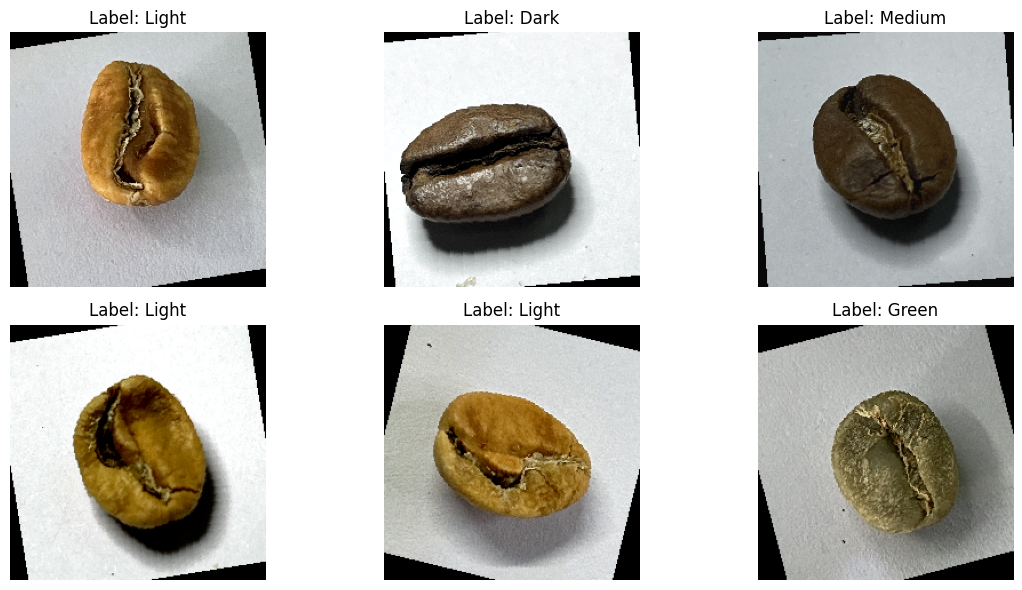

In [10]:
def show_sample_images(loader, class_map, num_images=6):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()
        label = labels[i].item()
        plt.subplot(2, 3, i+1)
        plt.imshow(image)
        plt.title(f"Label: {list(class_map.keys())[list(class_map.values()).index(label)]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images(train_loader, label_to_idx)

In [11]:
# Split only the training folder data
train_dataframe, valid_dataframe = train_test_split(
    train_df, test_size=0.18, stratify=train_df['label'], random_state=42
)

train_dataframe = train_dataframe.reset_index(drop=True)
valid_dataframe = valid_dataframe.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# Print dataset sizes
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amount of data: ", len(train_df) + len(test_df))

# Print class distribution
def print_distribution(title, dataframe):
    counts = dataframe['label'].value_counts().sort_index()
    table_data = [[cls, cnt] for cls, cnt in counts.items()]
    print(f"\n{title}")
    print(tabulate(table_data, headers=["Class", "Count"], tablefmt="pretty"))

print_distribution("Train Dataset", train_dataframe)
print_distribution("Validation Dataset", valid_dataframe)
print_distribution("Test Dataset", test_df)

Training Data:  984
Validation Data:  216
Test Data:  400
-------------------------------------------
Total amount of data:  1600

Train Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  246  |
| Green  |  246  |
| Light  |  246  |
| Medium |  246  |
+--------+-------+

Validation Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  54   |
| Green  |  54   |
| Light  |  54   |
| Medium |  54   |
+--------+-------+

Test Dataset
+--------+-------+
| Class  | Count |
+--------+-------+
|  Dark  |  100  |
| Green  |  100  |
| Light  |  100  |
| Medium |  100  |
+--------+-------+


In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
save_path_checkpoints = "/content/drive/MyDrive/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

In [14]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform):
        self.dataframe = dataframe
        self.transform = transform
        self.label_map = {'Dark': 0, 'Green': 1, 'Light': 2, 'Medium': 3}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        label_name = self.dataframe.iloc[index]['label']
        label = self.label_map[label_name]

        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)

        return image, label

In [15]:
train_batch = 32
val_batch = 8

def data_transform():
    # Define train and validation/test transforms separately
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor()
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Create datasets (no more is_lb flag)
    train_dataset = ImageDataset(train_dataframe, transform=train_transform)
    valid_dataset = ImageDataset(valid_dataframe, transform=val_test_transform)
    test_dataset = ImageDataset(test_df, transform=val_test_transform)

    # Create dataloaders
    dataloader_train = DataLoader(train_dataset, batch_size=train_batch, shuffle=True, num_workers=2)
    dataloader_valid = DataLoader(valid_dataset, batch_size=val_batch, shuffle=False, num_workers=2)
    dataloader_test  = DataLoader(test_dataset, batch_size=val_batch, shuffle=False, num_workers=2)

    return dataloader_train, dataloader_valid, dataloader_test

# Call to load data
dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transform()

In [16]:
# Load a pre-trained VGG model
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Replace the classifier to match the number of classes in your dataset
num_classes = 4
# VGG has a classifier as a Sequential module
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)


model = model.to(device)

# Optimizer and loss
learning_rate = 0.0001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Print model summary (optional, requires torchinfo)
from torchinfo import summary
summary(model, input_size=(train_batch, 3, 224, 224))

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:06<00:00, 86.4MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 4]                   --
├─Sequential: 1-1                        [32, 512, 7, 7]           --
│    └─Conv2d: 2-1                       [32, 64, 224, 224]        1,792
│    └─ReLU: 2-2                         [32, 64, 224, 224]        --
│    └─Conv2d: 2-3                       [32, 64, 224, 224]        36,928
│    └─ReLU: 2-4                         [32, 64, 224, 224]        --
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
│    └─Conv2d: 2-6                       [32, 128, 112, 112]       73,856
│    └─ReLU: 2-7                         [32, 128, 112, 112]       --
│    └─Conv2d: 2-8                       [32, 128, 112, 112]       147,584
│    └─ReLU: 2-9                         [32, 128, 112, 112]       --
│    └─MaxPool2d: 2-10                   [32, 128, 56, 56]         --
│    └─Conv2d: 2-11                      [32, 256, 56, 56]         29

In [17]:
num_epochs = 10

def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs, device, save_path):
    best_acc = 0.0
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        start_time_train = time.time()
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0

        for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct_predictions / total_predictions
        end_time_train = time.time()
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Train Acc: {epoch_acc:.4f} | Time: {end_time_train - start_time_train:.2f}s")

        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)


        # Validation phase
        start_time_val = time.time()
        model.eval()
        running_loss_val = 0.0
        correct_predictions_val = 0
        total_predictions_val = 0

        with torch.no_grad():
            for inputs_val, labels_val in tqdm(valid_loader, desc=f"Validating Epoch {epoch+1}/{num_epochs}"):
                inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

                outputs_val = model(inputs_val)
                loss_val = criterion(outputs_val, labels_val)

                running_loss_val += loss_val.item() * inputs_val.size(0)
                _, predicted_val = torch.max(outputs_val.data, 1)
                total_predictions_val += labels_val.size(0)
                correct_predictions_val += (predicted_val == labels_val).sum().item()

        epoch_loss_val = running_loss_val / len(valid_loader.dataset)
        epoch_acc_val = correct_predictions_val / total_predictions_val
        end_time_val = time.time()
        print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {epoch_loss_val:.4f} | Validation Acc: {epoch_acc_val:.4f} | Time: {end_time_val - start_time_val:.2f}s")

        val_loss_history.append(epoch_loss_val)
        val_acc_history.append(epoch_acc_val)

        # Save the best model
        if epoch_acc_val > best_acc:
            best_acc = epoch_acc_val
            torch.save(model.state_dict(), os.path.join(save_path, 'best_model.pth'))
            print(f"Saved best model with validation accuracy: {best_acc:.4f}")


    print("Finished Training")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

# Start training
start_time = time.time() # Kept start_time for calculating total time later

train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer,
    dataloader_train_dataset, dataloader_valid_dataset,
    num_epochs=num_epochs,
    device=device,
    save_path=save_path_checkpoints
)

end_time = time.time() # Kept end_time for calculating total time later
print(f"\n🕒 Total Training Time: {(end_time - start_time):.2f} seconds ({(end_time - start_time)/60:.2f} minutes)") # Kept printing total training time

# === Save training logs to Excel ===
import pandas as pd
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
excel_filename = f"/content/drive/MyDrive/working/training_data_{timestamp}.xlsx"

df = pd.DataFrame({
    "Epoch": list(range(1, len(train_loss_history) + 1)),
    "Train Loss": train_loss_history,
    "Train Accuracy": train_acc_history,
    "Validation Loss": val_loss_history,
    "Validation Accuracy": val_acc_history
})

df.to_excel(excel_filename, index=False)
print(f"📊 Saved full training history to {excel_filename}")

Training Epoch 1/10: 100%|██████████| 31/31 [04:32<00:00,  8.81s/it]


Epoch 1/10 | Train Loss: 0.6378 | Train Acc: 0.7368 | Time: 272.99s


Validating Epoch 1/10: 100%|██████████| 27/27 [00:57<00:00,  2.12s/it]


Epoch 1/10 | Validation Loss: 0.1677 | Validation Acc: 0.9259 | Time: 57.32s
Saved best model with validation accuracy: 0.9259


Training Epoch 2/10: 100%|██████████| 31/31 [00:24<00:00,  1.26it/s]


Epoch 2/10 | Train Loss: 0.2019 | Train Acc: 0.9329 | Time: 24.70s


Validating Epoch 2/10: 100%|██████████| 27/27 [00:02<00:00, 10.65it/s]


Epoch 2/10 | Validation Loss: 0.2692 | Validation Acc: 0.8843 | Time: 2.54s


Training Epoch 3/10: 100%|██████████| 31/31 [00:14<00:00,  2.11it/s]


Epoch 3/10 | Train Loss: 0.1694 | Train Acc: 0.9451 | Time: 14.68s


Validating Epoch 3/10: 100%|██████████| 27/27 [00:01<00:00, 16.76it/s]


Epoch 3/10 | Validation Loss: 0.0370 | Validation Acc: 0.9907 | Time: 1.62s
Saved best model with validation accuracy: 0.9907


Training Epoch 4/10: 100%|██████████| 31/31 [00:26<00:00,  1.18it/s]


Epoch 4/10 | Train Loss: 0.0267 | Train Acc: 0.9919 | Time: 26.37s


Validating Epoch 4/10: 100%|██████████| 27/27 [00:01<00:00, 16.53it/s]


Epoch 4/10 | Validation Loss: 0.0167 | Validation Acc: 0.9954 | Time: 1.64s
Saved best model with validation accuracy: 0.9954


Training Epoch 5/10: 100%|██████████| 31/31 [00:26<00:00,  1.16it/s]


Epoch 5/10 | Train Loss: 0.0158 | Train Acc: 0.9990 | Time: 26.71s


Validating Epoch 5/10: 100%|██████████| 27/27 [00:02<00:00, 12.68it/s]


Epoch 5/10 | Validation Loss: 0.1057 | Validation Acc: 0.9769 | Time: 2.14s


Training Epoch 6/10: 100%|██████████| 31/31 [00:15<00:00,  2.05it/s]


Epoch 6/10 | Train Loss: 0.0499 | Train Acc: 0.9888 | Time: 15.15s


Validating Epoch 6/10: 100%|██████████| 27/27 [00:01<00:00, 16.30it/s]


Epoch 6/10 | Validation Loss: 0.0815 | Validation Acc: 0.9722 | Time: 1.66s


Training Epoch 7/10: 100%|██████████| 31/31 [00:17<00:00,  1.73it/s]


Epoch 7/10 | Train Loss: 0.0357 | Train Acc: 0.9858 | Time: 17.93s


Validating Epoch 7/10: 100%|██████████| 27/27 [00:01<00:00, 16.30it/s]


Epoch 7/10 | Validation Loss: 0.0917 | Validation Acc: 0.9676 | Time: 1.66s


Training Epoch 8/10: 100%|██████████| 31/31 [00:14<00:00,  2.07it/s]


Epoch 8/10 | Train Loss: 0.0361 | Train Acc: 0.9878 | Time: 14.95s


Validating Epoch 8/10: 100%|██████████| 27/27 [00:01<00:00, 15.77it/s]


Epoch 8/10 | Validation Loss: 0.0229 | Validation Acc: 0.9861 | Time: 1.72s


Training Epoch 9/10: 100%|██████████| 31/31 [00:15<00:00,  1.98it/s]


Epoch 9/10 | Train Loss: 0.0217 | Train Acc: 0.9929 | Time: 15.66s


Validating Epoch 9/10: 100%|██████████| 27/27 [00:01<00:00, 13.58it/s]


Epoch 9/10 | Validation Loss: 0.0187 | Validation Acc: 0.9954 | Time: 1.99s


Training Epoch 10/10: 100%|██████████| 31/31 [00:15<00:00,  2.06it/s]


Epoch 10/10 | Train Loss: 0.0335 | Train Acc: 0.9898 | Time: 15.05s


Validating Epoch 10/10: 100%|██████████| 27/27 [00:01<00:00, 15.88it/s]


Epoch 10/10 | Validation Loss: 0.0428 | Validation Acc: 0.9861 | Time: 1.70s
Finished Training

🕒 Total Training Time: 533.72 seconds (8.90 minutes)
📊 Saved full training history to /content/drive/MyDrive/working/training_data_20250831_185730.xlsx


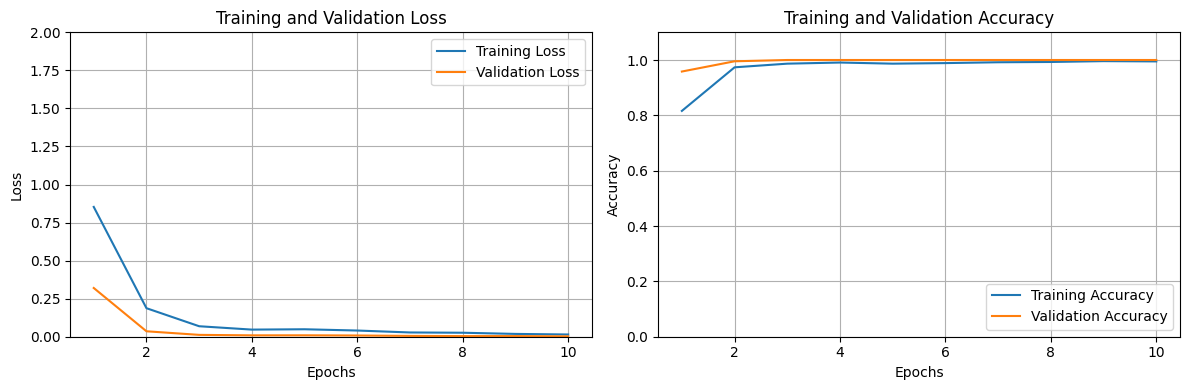

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Use the correct path to the saved Excel file
excel_filename = glob.glob("/content/drive/MyDrive/working/training_data_*.xlsx")[0] # Assuming only one file matches the pattern
history_df = pd.read_excel(excel_filename)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_df['Epoch'], history_df['Train Loss'], label='Train Loss')
plt.plot(history_df['Epoch'], history_df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)
plt.title('Training and Validation Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_df['Epoch'], history_df['Train Accuracy'], label='Train Accuracy')
plt.plot(history_df['Epoch'], history_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)
plt.title('Training and Validation Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [20]:
# Load the best model checkpoint
best_checkpoint_path = os.path.join(save_path_checkpoints, 'best_model.pth')

# Create a new instance of the VGG model
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
num_classes = 4
model.classifier[6] = nn.Linear(model.classifier[6].in_features, num_classes)
model = model.to(device) # Ensure the model is on the correct device

# Load the state dictionary
checkpoint = torch.load(best_checkpoint_path)
model.load_state_dict(checkpoint)
model.load_state_dict(torch.load(best_checkpoint_path))


# Evaluate the best model on the validation dataset
best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

# Evaluate the best model on the test dataset
start_time = time.time()
test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Best model - Test Loss: {test_loss:.3f}, Test Accuracy: {test_accuracy:.3f}")
end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Best model - Validation Loss: 0.017, Validation Accuracy: 0.995
Best model - Test Loss: 0.008, Test Accuracy: 0.998
Test Time: 132.47 seconds ---> 2.21 minutes


In [21]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Define the total number of classes based on your dataset
total_class = len(label_to_idx)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
# Use the actual class names from label_to_idx for the classification report
target_names = list(label_to_idx.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
# Print accuracy for each class using actual class names
print("\nClass Accuracy:")
for i in range(total_class):
    class_name = list(label_to_idx.keys())[i]
    print(f"Class '{class_name}' Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

        Dark       1.00      0.99      0.99       100
       Green       1.00      1.00      1.00       100
       Light       1.00      1.00      1.00       100
      Medium       0.99      1.00      1.00       100

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


Class Accuracy:
Class 'Dark' Accuracy: 0.990
Class 'Green' Accuracy: 1.000
Class 'Light' Accuracy: 1.000
Class 'Medium' Accuracy: 1.000


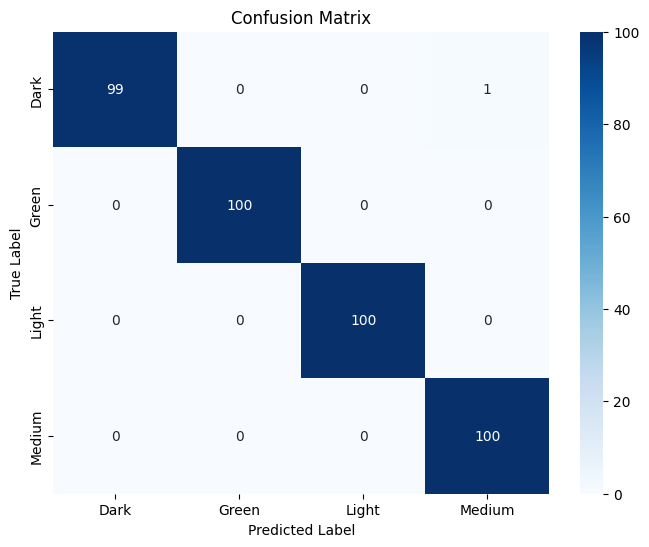

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get class names
class_names = list(label_to_idx.keys())

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

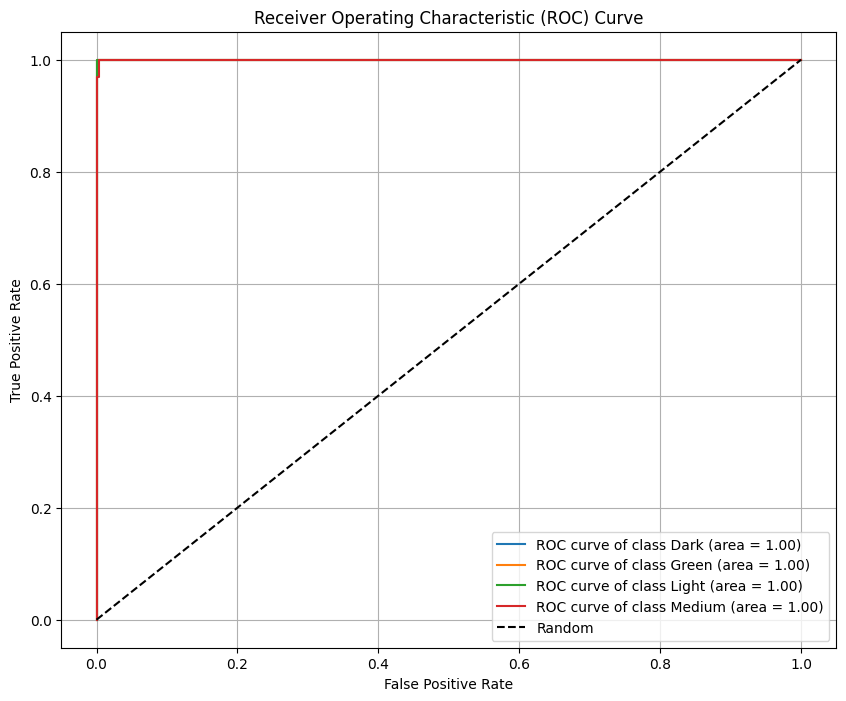


AUC for each class:
Class 'Dark' AUC: 1.000
Class 'Green' AUC: 1.000
Class 'Light' AUC: 1.000
Class 'Medium' AUC: 1.000


In [23]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Get predicted probabilities for the test set
y_score = []
model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs = inputs.to(device)
        outputs = model(inputs)
        y_score.extend(outputs.cpu().numpy())

y_score = np.array(y_score)

# Binarize the true labels for multi-class AUC
y_true_binarized = label_binarize(y_true, classes=list(label_to_idx.values()))
n_classes = y_true_binarized.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(n_classes):
    class_name = list(label_to_idx.keys())[i]
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_name} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print AUC for each class
print("\nAUC for each class:")
for i in range(n_classes):
     class_name = list(label_to_idx.keys())[i]
     print(f"Class '{class_name}' AUC: {roc_auc[i]:.3f}")